# Starter Notebook

Install and import required libraries

In [1]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstallin

In [2]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

2025-04-21 16:49:31.052308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745254171.225320      18 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745254171.273633      18 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import torch

print("cuda available? ", torch.cuda.is_available())
print("num GPUs:     ", torch.cuda.device_count())
if torch.cuda.is_available():
    print("current GPU:  ", torch.cuda.get_device_name(0))

cuda available?  True
num GPUs:      1
current GPU:   Tesla P100-PCIE-16GB


## Load Tokenizer and Preprocess Data

In [4]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [5]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [6]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [7]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [8]:
# PEFT Config
peft_config = LoraConfig(
    r=7,
    lora_alpha=32,
    lora_dropout=0.1,
    bias = 'none',
    target_modules = ['query', 'key', 'value'],
    task_type="SEQ_CLS",
)

In [9]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [10]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [11]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 980,740 || all params: 125,629,448 || trainable%: 0.7807


## Training Setup

In [12]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [13]:
from transformers import TrainerCallback
import json
import os

class StepwiseMetricsLoggerCallback(TrainerCallback):
    def __init__(self, path="/kaggle/working/step_metrics_log.json"):
        self.path = path
        self.history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            log_entry = {
                "step": state.global_step,
                **{k: v for k, v in logs.items() if isinstance(v, (int, float))}
            }
            self.history.append(log_entry)
            with open(self.path, "w") as f:
                json.dump(self.history, f, indent=4)


In [14]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to=[],
    eval_strategy='steps',
    eval_steps=50,
    save_strategy="steps",
    logging_strategy="steps",
    learning_rate=2.5e-4,
    logging_steps=50,
    num_train_epochs=2,
    max_steps=-1,
    no_cuda=False,
    fp16=torch.cuda.is_available(),
    dataloader_num_workers=4,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=64,
    gradient_accumulation_steps=2,
    optim="adamw_torch",
    weight_decay=0.01,
    warmup_ratio=0.1,
    gradient_checkpointing=False,
    metric_for_best_model="accuracy",
    load_best_model_at_end=True,
    greater_is_better=True,
)

def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
          callbacks=[StepwiseMetricsLoggerCallback()]
      )

### Start Training

In [15]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train()

torch.save(peft_model.state_dict(), "/kaggle/working/trained_model.pt")

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,1.380400,1.353404,0.556250,0.772931,0.556250,0.505506
100,0.877600,0.353522,0.867188,0.869454,0.867188,0.866915
150,0.340400,0.307008,0.904687,0.904909,0.904687,0.904067
200,0.302400,0.300706,0.898438,0.898351,0.898438,0.898145
250,0.310300,0.317295,0.887500,0.890813,0.887500,0.886563
300,0.287500,0.307958,0.903125,0.904627,0.903125,0.902813
350,0.284100,0.287500,0.901563,0.901844,0.901563,0.901091
400,0.258100,0.287226,0.907813,0.907856,0.907813,0.907803
450,0.249600,0.270725,0.904687,0.905212,0.904687,0.904688
500,0.237500,0.285068,0.914062,0.914834,0.914062,0.913902


## Plot the training metrics

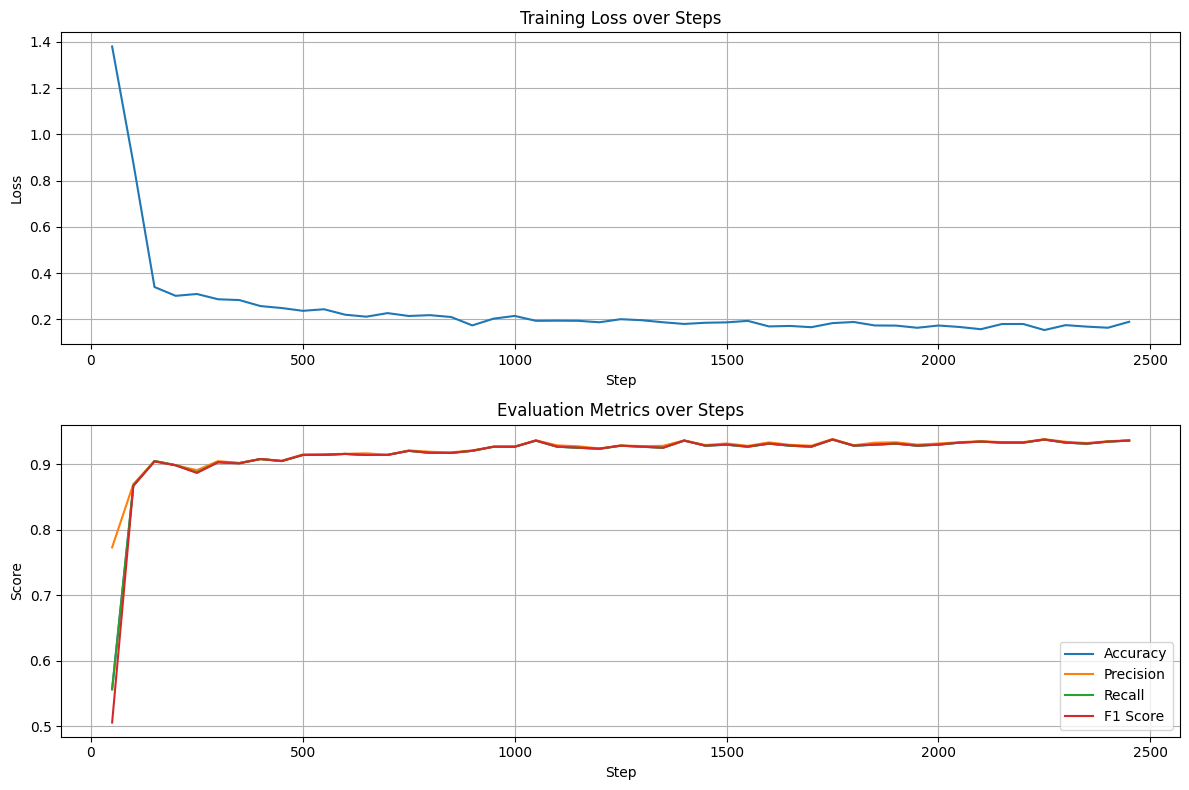

In [16]:
import json
import matplotlib.pyplot as plt

def plot_metrics_from_file(filepath):
    with open(filepath, "r") as f:
        data = json.load(f)

    # Separate training and evaluation logs
    train_steps, train_loss = [], []
    eval_steps, eval_loss, accuracy, precision, recall, f1 = [], [], [], [], [], []

    for entry in data:
        if "loss" in entry:
            train_steps.append(entry["step"])
            train_loss.append(entry["loss"])
        if "eval_loss" in entry:
            eval_steps.append(entry["step"])
            eval_loss.append(entry["eval_loss"])
            accuracy.append(entry["eval_accuracy"])
            precision.append(entry["eval_precision"])
            recall.append(entry["eval_recall"])
            f1.append(entry["eval_f1"])

    # Plotting
    plt.figure(figsize=(12, 8))

    # Training loss
    plt.subplot(2, 1, 1)
    plt.plot(train_steps, train_loss, label="Training Loss")
    plt.title("Training Loss over Steps")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.grid(True)

    # Evaluation metrics
    plt.subplot(2, 1, 2)
    if eval_steps:
        plt.plot(eval_steps, accuracy, label="Accuracy")
        plt.plot(eval_steps, precision, label="Precision")
        plt.plot(eval_steps, recall, label="Recall")
        plt.plot(eval_steps, f1, label="F1 Score")
    plt.title("Evaluation Metrics over Steps")
    plt.xlabel("Step")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()



plot_metrics_from_file("/kaggle/working/step_metrics_log.json")

## Evaluate Finetuned Model


In [17]:
peft_model.load_state_dict(torch.load("/kaggle/working/trained_model.pt", weights_only=True))
peft_model.eval()

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1, inplace=False)
                    )
                    (lora_A): Mod

In [18]:
def classify(model, tokenizer, text):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(**inputs)

    logits = output.logits
    prob = torch.nn.functional.softmax(logits, dim=-1)
    pred = logits.argmax(dim=-1).item()
    confidence = prob[0][pred].item()

    print(f'\n Class: {pred}, Label: {id2label[pred]}, Confidence: {confidence:.2f} \nText: {text}')
    print("\nProbabilities for all classes:")
    for key, val in id2label.items():
        print(f"{val}: {prob[0][key].item():.2f}")
    return id2label[pred]

In [19]:
classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")


 Class: 1, Label: Sports, Confidence: 0.97 
Text: Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...

Probabilities for all classes:
World: 0.03
Sports: 0.97
Business: 0.00
Sci/Tech: 0.00

 Class: 2, Label: Business, Confidence: 0.78 
Text: Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindlingand of ultra-cynics, are seeing green again.

Probabilities for all classes:
World: 0.19
Sports: 0.00
Business: 0.78
Sci/Tech: 0.03


'Business'

### Run Inference on eval_dataset

In [20]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [21]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:07<00:00, 11.28it/s]

Evaluation Metric: {'accuracy': 0.9140625}


### Run Inference on unlabelled dataset

In [22]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle("/kaggle/input/deep-learning-spring-2025-project-2/test_unlabelled.pkl")
test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [23]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [01:05<00:00, 15.36it/s]

Inference complete. Predictions saved to inference_output.csv


## Prediction Visualization

In [24]:

import matplotlib.pyplot as plt
import torch.nn.functional as F

def visualize_prediction(text, model, tokenizer, label_map):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=-1).squeeze().detach().cpu().numpy()

    plt.figure(figsize=(8, 4))
    plt.bar(label_map.values(), probs)
    plt.title(f"Prediction for: '{text}'")
    plt.ylabel("Probability")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

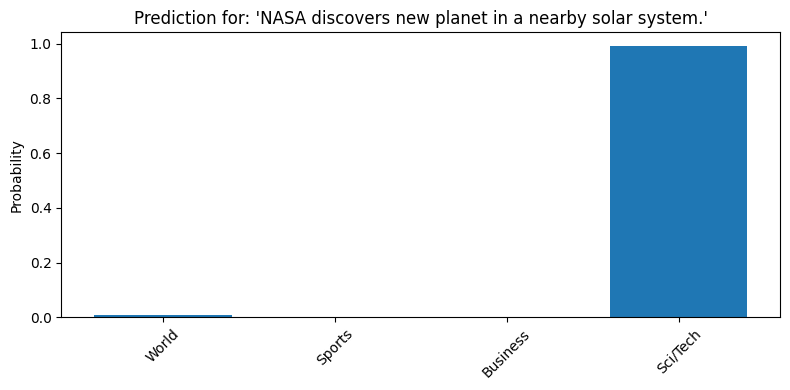

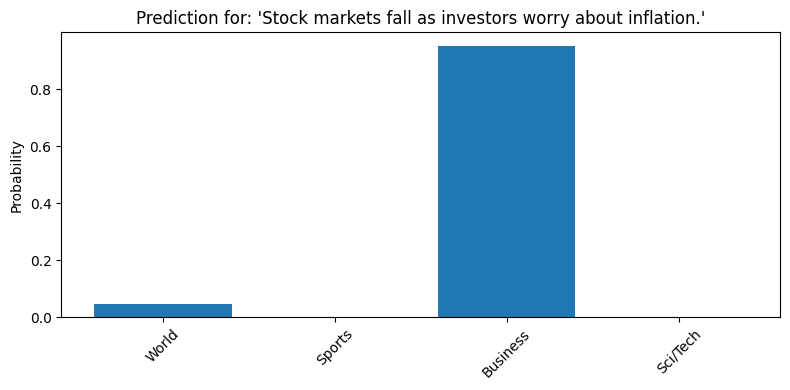

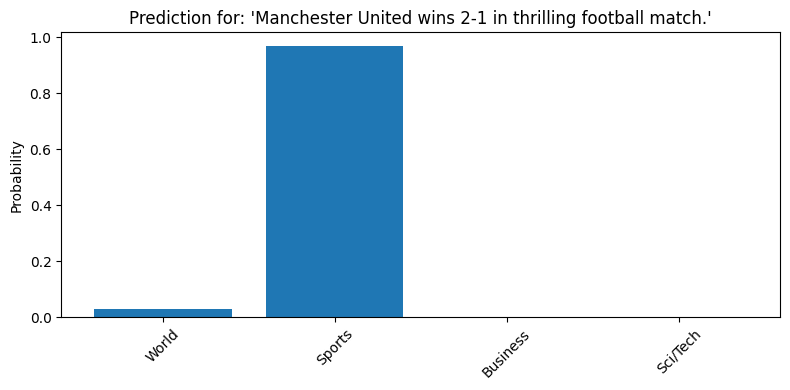

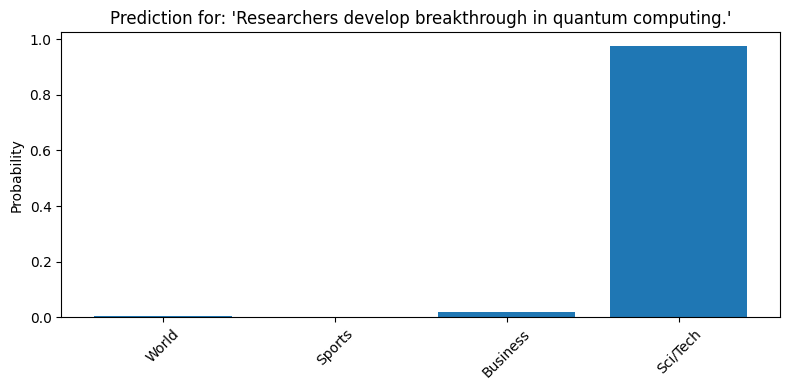

In [25]:
sample_texts = [
    "NASA discovers new planet in a nearby solar system.",
    "Stock markets fall as investors worry about inflation.",
    "Manchester United wins 2-1 in thrilling football match.",
    "Researchers develop breakthrough in quantum computing."
]

for text in sample_texts:
    visualize_prediction(text, peft_model, tokenizer, id2label)